In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import librosa
import soundfile as sound
import keras
import tensorflow
print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

Using TensorFlow backend.


Librosa version =  0.6.3
Pysoundfile version =  0.10.2
keras version =  2.2.4
tensorflow version =  1.12.0


In [3]:
#Task 1a dev validation set
ThisPath = '../Task1c/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 44100
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [4]:
#load filenames and labels
dev_test_df = pd.read_csv(File,sep='\t', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values
Inds_unknown=np.argwhere(y_val_labels==10)
Inds_known=np.argwhere(y_val_labels<10)

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

In [5]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,1),'float32')
for i in range(len(wavpaths)):
    audio_data,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
    LM_val[i,:,:,0]= librosa.feature.melspectrogram(audio_data, 
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val=np.log(LM_val)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

In [6]:
#load and run the model
best_model = keras.models.load_model('DCASE_Task1c_development.h5')
y_pred_raw = best_model.predict(LM_val)
y_pred_val = np.argmax(best_model.predict(LM_val),axis=1)


overall accuracy:  0.7392935982339955
Normalized confusion matrix
per-class accuracy (recall):  [0.68646081 0.87228916 0.83448276 0.76905312 0.89378238 0.69767442
 0.78684807 0.75524476 0.92288557 0.78899083 0.00289855]
per-class precision:  [0.78961749 0.81348315 0.75467775 0.78537736 0.92493298 0.62068966
 0.70528455 0.63905325 0.79273504 0.6394052  1.        ]
mean per-class recall:  0.7282373108195022
mean per-class precision:  0.7695687664634243
known class mean recall:  0.8007711868289886
unknown class  recall:  0.002898550724637681
known class mean precision:  0.7465256431097669
unknown class  precision:  1.0
DCASE Task1c evaluation:  0.4018348687768131


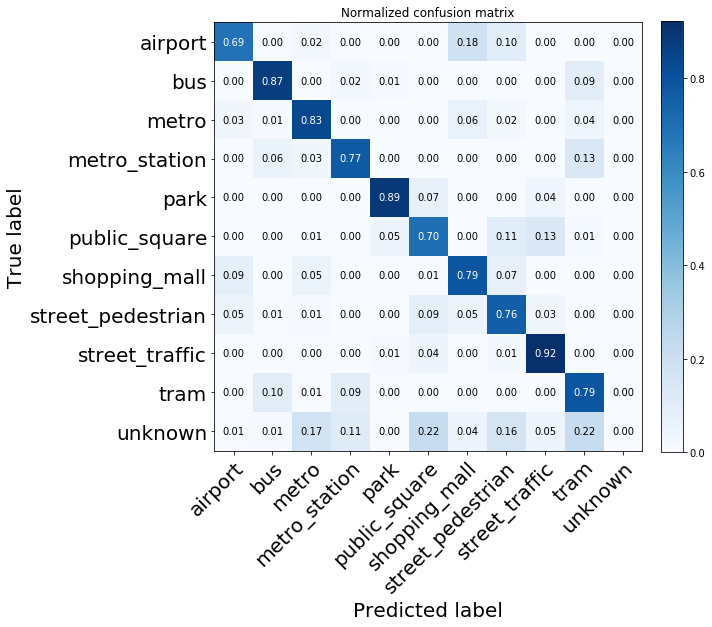

In [7]:
#get metrics without inference-time weighting for the unknown class
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

mean_recall_known = np.mean(recall_by_class[0:10])
mean_recall_unknown = np.mean(recall_by_class[10])
mean_precision_known = np.mean(precision_by_class[0:10])
mean_precision_unknown = np.mean(precision_by_class[10])
FinalAccuracy = mean_recall_unknown/2.0+mean_recall_known/2.0

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)
print("known class mean recall: ",mean_recall_known)
print("unknown class  recall: ",mean_recall_unknown)
print("known class mean precision: ",mean_precision_known)
print("unknown class  precision: ",mean_precision_unknown)
print("DCASE Task1c evaluation: ",FinalAccuracy)

overall accuracy:  0.6315673289183223
Normalized confusion matrix
per-class accuracy (recall):  [0.42755344 0.76385542 0.60229885 0.53810624 0.79792746 0.49870801
 0.60770975 0.47086247 0.86567164 0.62614679 0.80289855]
per-class precision:  [0.87804878 0.93510324 0.95620438 0.91372549 0.94478528 0.7689243
 0.8427673  0.72661871 0.9015544  0.83742331 0.17620865]
mean per-class recall:  0.6365216933108626
mean per-class precision:  0.8073967130006919
known class mean recall:  0.6198840075694851
unknown class  recall:  0.8028985507246377
known class mean precision:  0.8705155191608119
unknown class  precision:  0.1762086513994911
DCASE Task1c evaluation:  0.7113912791470614


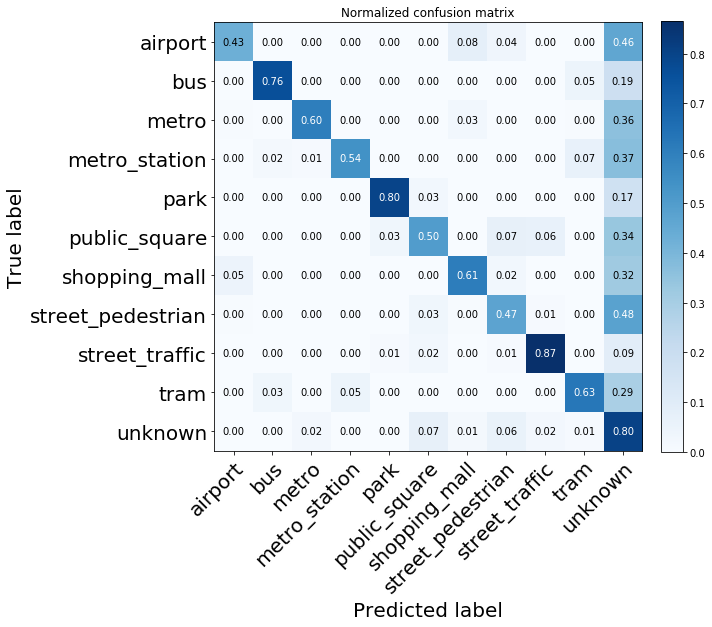

In [8]:
#get metrics using inference-time weighting for the unknown class

weightings = [1,1,1,1,1,1,1,1,1,1,5]
y_pred_val_weighted = np.argmax(weightings*y_pred_raw,axis=-1)

Overall_accuracy = np.sum(y_pred_val_weighted==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val_weighted, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val_weighted)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

mean_recall_known = np.mean(recall_by_class[0:10])
mean_recall_unknown = np.mean(recall_by_class[10])
mean_precision_known = np.mean(precision_by_class[0:10])
mean_precision_unknown = np.mean(precision_by_class[10])
FinalAccuracy = mean_recall_unknown/2.0+mean_recall_known/2.0

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)
print("known class mean recall: ",mean_recall_known)
print("unknown class  recall: ",mean_recall_unknown)
print("known class mean precision: ",mean_precision_known)
print("unknown class  precision: ",mean_precision_unknown)
print("DCASE Task1c evaluation: ",FinalAccuracy)